# Testing Image Analysis

The beginning of this document is me learning how to use the OpenCV image analysis tools. This will help me understand how to analyze each of the images in my data set. Below, the 'cv2.imread' function works to read in the image as a np array. Next I define the SURF detection analyzer, with a Hessian threshold of 5000 (something told me the higher the better, but around 500 is the best option). Next I apply the detetor to the images to retrieve their keypoints and descriptors. 

In [145]:
img1 = cv2.imread('Wikiart/alberto-sotio/madonna-in-maesta.jpg', 0)
img2 = cv2.imread('Wikiart/alberto-sotio/madonna-di-ambro.jpg', 0)



In [25]:
surf = cv2.xfeatures2d.SURF_create(5000)

kp1, des1 = surf.detectAndCompute(img1, None)
kp2, des2 = surf.detectAndCompute(img2, None)


print(len(kp1))


1783


In [26]:
img1_kp = cv2.drawKeypoints(img1, kp, None, (255,0,0), 4)
img2_kp = cv2.drawKeypoints(img2, kp, None, (255,0,0), 4)


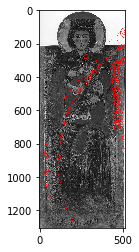

(<matplotlib.image.AxesImage at 0x11e5b3588>, None)

In [27]:
plt.imshow(img2_kp), plt.show()


Finally I take both images and show the keypoints that are matched by a brute force matcher, and see where they are matched. While looking at the matches is interesting, in the analysis aspect this image doesn't have much meaning. So instead I will focus on something else later on. 

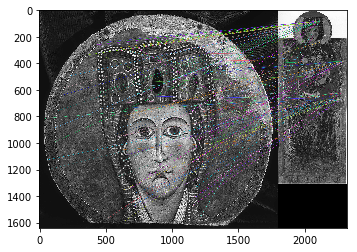

(<matplotlib.image.AxesImage at 0x115b41cc0>, None)

In [43]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img1_2 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)

plt.imshow(img1_2),plt.show()


In [35]:
print(len(des1), len(des1[0]), len(des2), len(des2[0]))



1783 64 43 64


In [38]:
len(good)

123

Below is me comparing the above image and comparing it to an image, a picture of me playing lacrosse, that should have little similarity. I can see that it is in fact matches less keypoints than the original comparison did. This is good. 

In [60]:
img3 = cv2.imread('IMG_3473.PNG', 0)

In [61]:
kp3, des3 = surf.detectAndCompute(img3, None)
img3_kp = cv2.drawKeypoints(img3, kp, None, (255,0,0), 4)

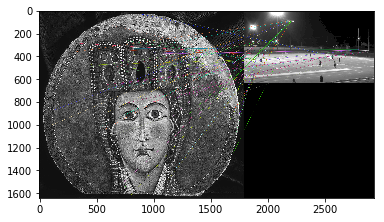

(<matplotlib.image.AxesImage at 0x115c1d0f0>, None)

In [62]:
matches = bf.knnMatch(des1,des3, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img1_3 = cv2.drawMatchesKnn(img1,kp1,img3,kp3,good,None,flags=2)

plt.imshow(img1_3),plt.show()

In [63]:
len(good)

57

# Functions for Analysis

When analyzing the images, I can use the 'good' matches found from SURF and the BFmatcher(Maybe find another one). If the year of painting i is less than that of painting j, we use this similarity. Other wise it is just represented as 0 in the adjacency matrix. 

Divide painting j describers by that of painting i. So painting one in my example has 1783, a perfect match would match all the descriptors. 

Talk about the genre similarity (although if I am using a pre determined genre this wont work), style similarity, 

In [315]:
rel_paintDF = pd.read_csv('rel_paint.csv', index_col=0)

* "compareImg": This function takes a data frame as the input, specifically the one defined above. Then creates a new empty adjacency matrix that will be used for creating the weighted similarity edges for the paintings. The only way the matrix is populated is through looking at the paintings in years following the painting you are currently looking at. This matrix is then returned

* "retrieveMtch": This function takes in two image paths, and then is put through the same detection that was used above. However, instead of graphing the matches, I do a simple count and compare it to the min number of keypoints between the two paintings. This is because more key points cant be matched than already exist. Then the ratio of matches to the min keypoints is returned. This is our creativity score for the features. 


In [316]:
def compareImg(df):
    #need to initialize the adjacency matrix for creativity
    #Standard way to get range between 0
    m = np.zeros((len(df), len(df)))
    for p in df.index:
        #print(df.iloc[df.index.get_loc(p) + 1:].index)
        #for each painting after the current painting. They should be sorted by year
        for pC in df.iloc[df.index.get_loc(p) + 1:].index:
            if df.loc[p]['Year'] < df.loc[pC]['Year']:

                #print(df.loc[p]['Path'], df.loc[pC]['Path'])
                r = retrieveMtch(df.loc[p]['Path'], df.loc[pC]['Path'])
                m[df.index.get_loc(p)][df.index.get_loc(pC)] = r
                
    return m

#defined outside, this way it doesn't get recreated everytime               
surf = cv2.xfeatures2d.SURF_create(5000)


                
                
def retrieveMtch(path1, path2):
    img1 = cv2.imread(path1, 0)
    img2 = cv2.imread(path2, 0)
    
    #print(path1, path2)
    kp1, des1 = surf.detectAndCompute(img1, None)
    kp2, des2 = surf.detectAndCompute(img2, None)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    mx = min(len(kp1), len(kp2))
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])
    # ratio of the total num of matches vs the max number of keypoints that could have been matched. 
    # that max is the min number of keypoints between the two paintings. 
    ratio = len(good)/mx
            
    return ratio
    

* "temporalNeighbors": This function is for finding the k closest paintings to the current index. Taking in a dataframe, an index, and a k value for locating these values. The original idea is to apply this once the balancing function has been applied. 

* "balanceW": This function will take in an input array, in theory the adjacency matrix, and creates a new matrix of the same size. Then a weight, taken by the percentile function from np, is checked against each of the values in the array. If subtracting the value produced a negative weight, the edge is reversed. From i -> j now i <- j. Otherwise it remains 0 or the weight is just the positive version of the original weight minus the balancing value. Returns this new array. 

* "normalizeNP": This function take s in a np array as its input, and then takes the sum of the row. Then divides each cell by that total. If the total is 0, then the cells are given equal weights. This is returned. 

In [496]:
#When using the balancing function I need to change the ij value to ji, and then set ij to 0 and ji to pos(ij)
import math
#will return a list of size k, or max num of neighbors of the indices of the nearest neighbors
def temporalNeighbors(df, i, k):
    curY = df.iloc[i]['Year']

    if k > (len(df) - len(df.loc[df['Year'] == curY])):
        k = len(df) - len(df.loc[df['Year'] == curY]) - 1
                
    ind = list(np.zeros(k))
    n = list(np.full(k, np.inf))
    
    
    for j in range(len(df) - 1):
        tY = df.iloc[j]['Year']
        if tY != curY:
            #get the dif of years
            if abs(tY - curY) < max(n):
                idx = n.index(max(n))
                #set the values if this is less than the max number in n
                n[idx] = abs(tY - curY)
                ind[idx] = j
                
    print(ind)
    
    return ind

# Maybe output two arrays, the ones that stay with the subsequent paintings
# then the other that outputs the prior ones (the ones whoes weights switch between i and j)

def balanceW(inpAr):
    ar = np.zeros((len(inpAr), len(inpAr)))
#     m = np.average(ar) #maybe change this to the percentile function
    m = np.percentile(inpAr, 80)
    for i in range(len(ar)):
        for j in range(len(ar[i])):
            newW = inpAr[i][j] - m
            if inpAr[i][j] == 0:
                pass
            elif newW > 0:
                ar[i][j] = newW
            else:
                # this will swap the direciton of the edges of influence essentially. 
                ar[j][i] = -newW
#                 ar[i][j] = 0
    # return balanced version of the array
    #this way I can have both
    return ar

# this is for normalizing the array for the markovChains
def normalizeNP(inpAr):
    ar = np.zeros((len(inpAr), len(inpAr)))
    print(ar)
    for i in range(len(ar)):
        tot = sum(inpAr[i])
        print(tot)
        if tot > 0.0:
            for j in range(len(ar)):
                ar[i][j] = inpAr[i][j] / tot
            
    print(ar)
    return ar

## Testing Functions

To test these functions I applied them to a small subset of my origional data. 

In [497]:
rel_paintDF_test = rel_paintDF.drop_duplicates('Year')[:5]
rel_paintDF_test

,Artist,Link Ext,Path,Year,Genre
Maestà duccio,duccio,/en/duccio/maesta-1280,Wikiart/duccio/maesta-1280.jpg,1280,religious painting
Madonna of Crevole duccio,duccio,/en/duccio/madonna-of-crevole-1284,Wikiart/duccio/madonna-of-crevole-1284.jpg,1284,religious painting
Madonna and Child duccio,duccio,/en/duccio/madonna-and-child-1305,Wikiart/duccio/madonna-and-child-1305.jpg,1305,religious painting
Saint Catherine of Alexandria Polyptych simone martini,simone martini,/en/simone-martini/saint-catherine-of-alexandr...,Wikiart/simone-martini/saint-catherine-of-alex...,1319,religious painting
Crucifix pietro lorenzetti,pietro lorenzetti,/en/pietro-lorenzetti/crucifix,Wikiart/pietro-lorenzetti/crucifix.jpg,1320,religious painting


In [498]:
test = compareImg(rel_paintDF_test)

In [499]:
test

array([[0.        , 0.04761905, 0.        , 0.        , 0.03174603],
       [0.        , 0.        , 0.17142857, 0.01282051, 0.03846154],
       [0.        , 0.        , 0.        , 0.05714286, 0.02857143],
       [0.        , 0.        , 0.        , 0.        , 0.15384615],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [500]:
t = temporalNeighbors(rel_paintDF, 10, 2)

[14, 9]


In [501]:
# gives the average of the weights. This can be used for the balance function threshold.
# This will matter when looking at whether to reverse an edge or not. 
a = np.average(test)

In [502]:
testB = balanceW(test)

In [503]:
testB

array([[0.        , 0.01452991, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.13833944, 0.        , 0.00537241],
       [0.        , 0.        , 0.        , 0.02405372, 0.        ],
       [0.        , 0.02026862, 0.        , 0.        , 0.12075702],
       [0.0013431 , 0.        , 0.0045177 , 0.        , 0.        ]])

In [504]:
#this could be useful if I just want to use the pth percentile instead of the average. 

np.percentile(test, 75)

0.02857142857142857

This is me testing the Random Markov Chain functions. 

In [505]:
P = np.array([[0.5,0.5],[0.6,0.4]])
mc = markovChain(P)
mc.computePi('linear') #We can also use 'power', 'krylov' or 'eigen'
print(mc.pi)

[0.54545455 0.45454545]


In [506]:

testN = normalizeNP(testB)


[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
0.014529914529914506
0.14371184371184367
0.02405372405372403
0.14102564102564102
0.005860805860805906
[[0.         1.         0.         0.         0.        ]
 [0.         0.         0.96261682 0.         0.03738318]
 [0.         0.         0.         1.         0.        ]
 [0.         0.14372294 0.         0.         0.85627706]
 [0.22916667 0.         0.77083333 0.         0.        ]]


Now I will be testing the markovChain, which will give me my final creativity score. This represents a random walk through the normalized (probability) matrix that I create. 

In [507]:
mc = markovChain(testN)
mc.computePi('linear')
print(mc.pi)

[0.05838719 0.10052043 0.29315595 0.29315595 0.25478048]


In [508]:
rel_paintDF_test["Creativity Score"] = np.asarray(mc.pi)

In [509]:
rel_paintDF_test

,Artist,Link Ext,Path,Year,Genre,Creativity Score
Maestà duccio,duccio,/en/duccio/maesta-1280,Wikiart/duccio/maesta-1280.jpg,1280,religious painting,0.058387
Madonna of Crevole duccio,duccio,/en/duccio/madonna-of-crevole-1284,Wikiart/duccio/madonna-of-crevole-1284.jpg,1284,religious painting,0.100520
Madonna and Child duccio,duccio,/en/duccio/madonna-and-child-1305,Wikiart/duccio/madonna-and-child-1305.jpg,1305,religious painting,0.293156
Saint Catherine of Alexandria Polyptych simone martini,simone martini,/en/simone-martini/saint-catherine-of-alexandr...,Wikiart/simone-martini/saint-catherine-of-alex...,1319,religious painting,0.293156
Crucifix pietro lorenzetti,pietro lorenzetti,/en/pietro-lorenzetti/crucifix,Wikiart/pietro-lorenzetti/crucifix.jpg,1320,religious painting,0.254780


# Test Graph

This is the test of the results from the creativity graph. 

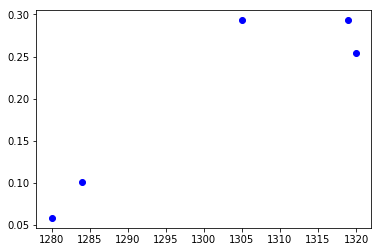

In [513]:
plt.plot(rel_paintDF_test['Year'], rel_paintDF_test['Creativity Score'], 'bo')
plt.show()